In [1]:
import os
import pandas as pd
import numpy as np

def load_titanic_data(filename, folder="Data"):
    csv_path = os.path.join(folder, filename)
    return pd.read_csv(csv_path)

In [62]:
titanic_train = load_titanic_data("train.csv")
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


So initial lessons to learn: Age has over 150 missing values which is significant in this dataset size Cabin has 22% population which is very poor could initially transform into a new column of has cabin which is binary, not sure if a location from cabin can be gleaned to help predict survival rates based on where in the ship passengers had cabins? Maybe those with cabins could be more likely to have been in them at the time of sinking?

Need to remove PassengerId from training process

Only numerical fields which are related numerical - age and fare. The rest are categorical

In [4]:
204/891 * 100 #Cabin population rate

22.895622895622896

In [866]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


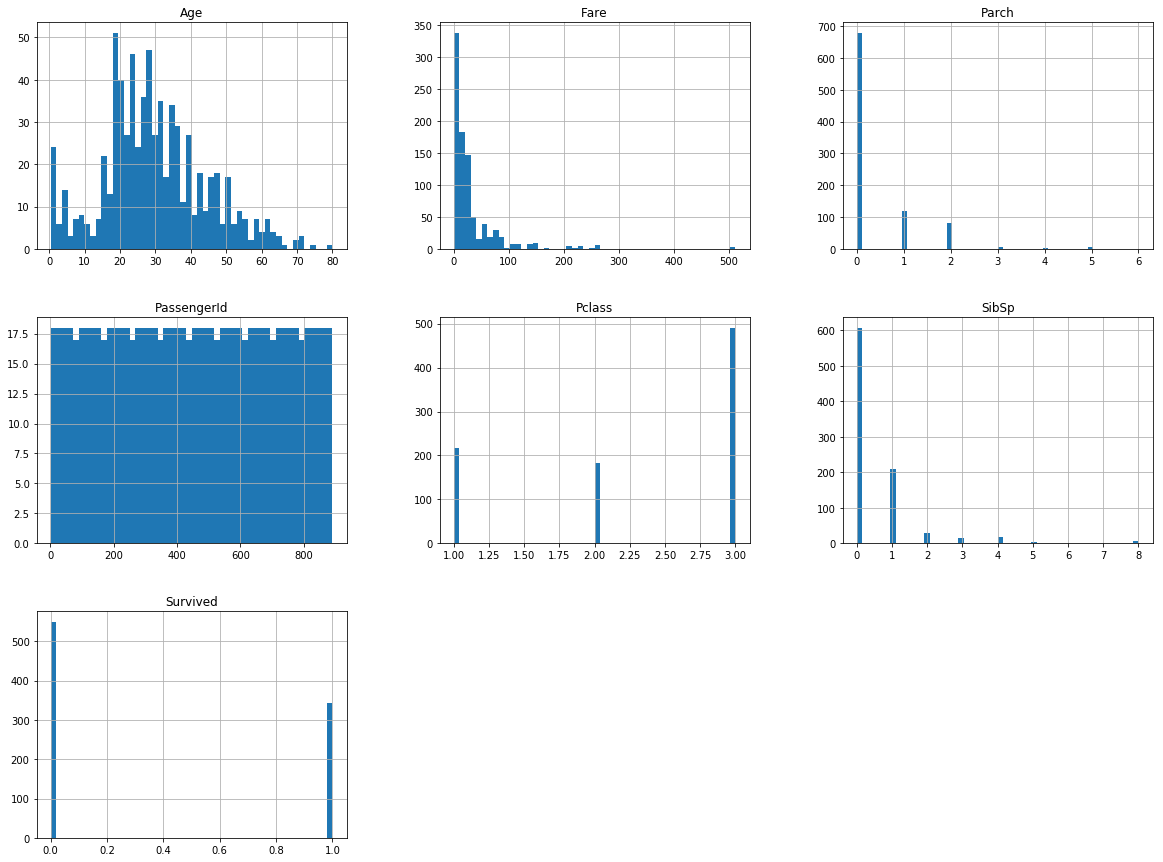

In [506]:
%matplotlib inline
import matplotlib.pyplot as plt
titanic_train.hist(bins=50, figsize=(20,15))
plt.show()

Splitting out a title field from the name seems sensible and setting it's values to true/false
Flagging if a passenger had a Cabin or not - perhaps cabin type matters as well
Trying to combine Parch and SibSp into a Family feature - saw someone else had done this and sounded sensible

In [834]:
def AddTitle(data):
    data["Mr"] = 0
    data["Mrs"] = 0
    data["Master"] = 0
    data["Miss"] = 0
    data["Other"] = 0
    data.loc[data["Name"].str.contains("Mr.", regex=False), "Mr"] = 1
    data.loc[data["Name"].str.contains("Mrs.", regex=False), "Mrs"] = 1
    data.loc[data["Name"].str.contains("Master.", regex=False), "Master"] = 1
    data.loc[data["Name"].str.contains("Miss.", regex=False), "Miss"] = 1
    data.loc[data["Mr"] + data["Mrs"] + data["Master"] + data["Miss"] == 0, "Other"] = 1
    
def AddTitleCategory(data):
    data["Title"] = "Other"
    data.loc[data["Name"].str.contains("Mr.", regex=False), "Title"] = "Mr."
    data.loc[data["Name"].str.contains("Mrs.", regex=False), "Title"] = "Mrs."
    data.loc[data["Name"].str.contains("Master.", regex=False), "Title"] = "Master."
    data.loc[data["Name"].str.contains("Miss.", regex=False), "Title"] = "Miss."
    
def AddHasCabin(data):
    data["HasCabin"] = data["Cabin"]
    data["HasCabin"] = data["HasCabin"].fillna(value=0)
    data.loc[data["HasCabin"] != 0, "HasCabin"] = 1
    
def CombineFamily(data):
    data["Family"] = data["Parch"] + data["SibSp"]
    
def CabinType(data):
    data["CabinLetter"] = data["Cabin"].str[0]
    
def AgeBracketsCategory(data):
    data["AgeBracket"] = ""
    data.loc[data["Age"] < 3, "AgeBracket"] = "Baby"
    data.loc[(data["Age"] >= 3) & (data["Age"] < 9), "AgeBracket"] = "Child"
    data.loc[(data["Age"] >= 9) & (data["Age"] < 15), "AgeBracket"] = "OldChild"
    data.loc[(data["Age"] >= 15) & (data["Age"] < 22), "AgeBracket"] = "YoungAdult"
    data.loc[(data["Age"] >= 22) & (data["Age"] < 40), "AgeBracket"] = "Adult"
    data.loc[data["Age"] >= 40, "AgeBracket"] = "OldAdult"
    
def AgeBrackets(data):
    data["Baby"] = 0
    data["Child"] = 0
    data["YoungAdult"] = 0
    data["Adult"] = 0
    data["OldAdult"] = 0
    data.loc[data["Age"] < 3, "Baby"] = 1
    data.loc[(data["Age"] >= 3) & (data["Age"] < 9), "YoungChild"] = 1
    data.loc[(data["Age"] >= 9) & (data["Age"] < 15), "OldChild"] = 1
    data.loc[(data["Age"] >= 15) & (data["Age"] < 22), "YoungAdult"] = 1
    data.loc[(data["Age"] >= 22) & (data["Age"] < 40), "Adult"] = 1
    data.loc[data["Age"] >= 40, "OldAdult"] = 1
    
#Got fare details from: http://www.keyflux.com/titanic/facts.htm 
#However the brackets don't overlap well so making sure all values are covered
def FareBrackets(data):
    data["NoFare"] = 0
    data["ThirdClass"] = 0
    data["SecondClass"] = 0
    data["FirstClassBerthA"] = 0
    data["FirstClassBerthB"] = 0
    data["FirstClassParlourSuite"] = 0
    data.loc[data["Fare"] == 0, "NoFare"] = 1
    data.loc[(data["Fare"] > 0) & (data["Fare"] <= 8), "ThirdClass"] = 1
    data.loc[(data["Fare"] > 8) & (data["Fare"] <= 30), "SecondClass"] = 1
    data.loc[(data["Fare"] > 30) & (data["Fare"] < 870), "FirstClassBerth"] = 1
    #data.loc[(data["Fare"] > 30) & (data["Fare"] <= 75), "FirstClassBerthA"] = 1 #Splitting as there appears to be less survival below 75 fare
    #data.loc[(data["Fare"] > 75) & (data["Fare"] < 870), "FirstClassBerthB"] = 1
    data.loc[data["Fare"] >= 870, "FirstClassParlourSuite"] = 1 #Doesn't look like any data points hit this but leaving in anyway
    
def FareBracketsCategory(data):
    data["TicketType"] = ""
    data.loc[data["Fare"] == 0, "TicketType"] = "NoFare"
    data.loc[(data["Fare"] > 0) & (data["Fare"] <= 8), "TicketType"] = "ThirdClass"
    data.loc[(data["Fare"] > 8) & (data["Fare"] <= 30), "TicketType"] = "SecondClass"
    data.loc[(data["Fare"] > 30) & (data["Fare"] < 870), "TicketType"] = "FirstClassBerth"
    #data.loc[(data["Fare"] > 30) & (data["Fare"] <= 75), "TicketType"] = "FirstClassBerthA" #Splitting as there appears to be less survival below 75 fare
    #data.loc[(data["Fare"] > 75) & (data["Fare"] < 870), "TicketType"] = "FirstClassBerthB"
    data.loc[data["Fare"] >= 870, "TicketType"] = "FirstClassParlourSuite" #Doesn't look like any data points hit this but leaving in anyway

Diving in and looking at some classification to see how it looks as a first pass. Still need to do more work on unused fields currently

In [878]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

titanic_training = titanic_train.copy()

def PrepData(data):
    AddTitle(data)
    AddHasCabin(data)
    CombineFamily(data)
    data.Embarked.fillna('S', inplace=True)
    data.loc[data["Embarked"] == "", "Embarked"] = "S"
    data.Cabin.fillna('Z', inplace=True)
    data.Age.fillna((data["Age"].mean()), inplace=True)
    CabinType(data)
    AgeBrackets(data)
    FareBrackets(data)
    AddTitleCategory(data)
    AgeBracketsCategory(data)
    FareBracketsCategory(data)
    
cat_attribs = ["Sex","Embarked","Pclass","Title","TicketType","AgeBracket"]
num_attribs = ["Age", "Fare", "Family","HasCabin"]
print(num_attribs)
print(cat_attribs)

#train_set, test_set = train_test_split(titanic_training, test_size=0.2, random_state=42)
   
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from future_encoders import OneHotEncoder

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    #('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

#train_labels, test_labels = train_set["Survived"], test_set["Survived"]
train_labels = titanic_training["Survived"]
PrepData(titanic_training)

print(titanic_training.head(10))
print(titanic_training.info())
titanic_prepared = full_pipeline.fit_transform(titanic_training)

['Age', 'Fare', 'Family', 'HasCabin']
['Sex', 'Embarked', 'Pclass', 'Title', 'TicketType', 'AgeBracket']
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex        Age  \
0                            Braund, Mr. Owen Harris    male  22.000000   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.000000   
2                             Heikkinen, Miss. Laina  female  26.000000   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.000000   
4                           Allen, Mr. William Henry    male  35.000000   
5                                   Moran, Mr. J

In [879]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(titanic_prepared, train_labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [880]:
cross_val_score(sgd_clf, titanic_prepared, train_labels, cv=3, scoring="accuracy")

array([0.48148148, 0.79124579, 0.78787879])

In [881]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(titanic_prepared, train_labels)
cross_val_score(forest_clf, titanic_prepared, train_labels, cv=3, scoring="accuracy")

array([0.77104377, 0.81144781, 0.77441077])

In [882]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(titanic_prepared, train_labels)
cross_val_score(knn_clf, titanic_prepared, train_labels, cv=3, scoring="accuracy")

array([0.77441077, 0.83164983, 0.83501684])

Initial results are poor but promising. I feel like some parameter tuning could help but there's probably more need for improvement in the input parameters

In [883]:
#Using iris example as a way of throwing a few algorithms at the issue and see how they perform
import pandas
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# Test options and evaluation metric
seed = 42
scoring = 'accuracy'

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, titanic_prepared, train_labels, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.824906 (0.038041)
LDA: 0.826067 (0.034729)
KNN: 0.826092 (0.043884)
CART: 0.776754 (0.061125)
NB: 0.764332 (0.042791)


C:\Users\NickSandel\AppData\Local\conda\conda\envs\mlbook\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\NickSandel\AppData\Local\conda\conda\envs\mlbook\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\NickSandel\AppData\Local\conda\conda\envs\mlbook\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\NickSandel\AppData\Local\conda\conda\envs\mlbook\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\NickSandel\AppData\Local\conda\conda\envs\mlbook\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\NickSandel\

SVM: 0.832784 (0.041821)
RF: 0.807016 (0.030834)


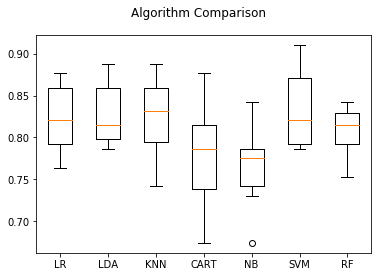

In [884]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [885]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid = {
        'n_estimators': randint(low=20, high=200),
        'max_features': randint(low=7, high=10),
    }

forest_clf = RandomForestClassifier(random_state=42)
grid_search = RandomizedSearchCV(forest_clf, param_grid, n_iter = 20, cv=5, return_train_score=False)
grid_search.fit(titanic_prepared, train_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BEBA522A20>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BEBA4A8FD0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=False, scoring=None, verbose=0)

In [886]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

array = []
cvres = grid_search.cv_results_
for mean_score, features, estimators in zip(cvres["mean_test_score"], cvres["param_max_features"], cvres["param_n_estimators"]):
    print(np.sqrt(mean_score), 'max_features:', features, 'n_estimators:', estimators)
    array.append([np.sqrt(mean_score),features,estimators])
    
print(sorted(array, reverse=True))

feature_importances = grid_search.best_estimator_.feature_importances_
#sorted(feature_importances)

#extra_attribs = ["Mr","Mrs","Master","Miss","Other","HasCabin","Family","CabinLetter","Baby","Child","YoungAdult","Adult","OldAdult"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = []
for i in range(len(cat_encoder.categories_)):
    cat_one_hot_attribs = cat_one_hot_attribs + list(cat_encoder.categories_[i])# + list(cat_encoder.categories_[1]) + list(cat_encoder.categories_[2]) + list(cat_encoder.categories_[3])
print(num_attribs, cat_one_hot_attribs)
attributes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse = True)

{'max_features': 9, 'n_estimators': 41}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=41, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
0.8958064164776166 max_features: 8 n_estimators: 75
0.8983086739117798 max_features: 9 n_estimators: 173
0.8989331499509894 max_features: 9 n_estimators: 73
0.8964326356498501 max_features: 8 n_estimators: 169
0.8964326356498501 max_features: 8 n_estimators: 148
0.8976837634542982 max_features: 8 n_estimators: 47
0.8964326356498501 max_features: 8 n_estimators: 48
0.8983086739117798 max_features: 9 n_estimators: 125
0.8970584176706692 max_features: 8 n_estimators: 104
0.8976837634542982 max_features: 7 n_estimators: 151
0.9039134271190744 max_features:

[(0.19606125731889457, 'Fare'),
 (0.18867779979707178, 'Age'),
 (0.11295618452397974, 'Mr.'),
 (0.09308705385356532, 'female'),
 (0.08415467011726835, 'male'),
 (0.07038562630121097, 'Family'),
 (0.04088237568736952, 3),
 (0.029094345888700003, 'HasCabin'),
 (0.02259815941054044, 1),
 (0.017607670127257585, 'Miss.'),
 (0.01590784779108643, 2),
 (0.013316832696984991, 'C'),
 (0.012628070730801907, 'Master.'),
 (0.011856994702064295, 'Adult'),
 (0.011556587675591555, 'Mrs.'),
 (0.011364335467281382, 'S'),
 (0.008910120571186642, 'SecondClass'),
 (0.00847570969485731, 'FirstClassBerth'),
 (0.008221423305350683, 'ThirdClass'),
 (0.007792262222960386, 'YoungAdult'),
 (0.007774304464372262, 'Q'),
 (0.0075684537876526065, 'OldAdult'),
 (0.006015870690756853, 'Other'),
 (0.004567003727242314, 'Baby'),
 (0.0036351205985939647, 'OldChild'),
 (0.0034255083317295426, 'Child'),
 (0.0014784105156286469, 'NoFare')]

In [887]:
#scores_df = pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score')
#scores_df

In [890]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11], 'weights': ["uniform","distance"]},
]

knn_clf = KNeighborsClassifier(n_jobs=-1)
grid_search_knn = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search_knn.fit(titanic_prepared, train_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [891]:
print(grid_search_knn.best_params_)
print(grid_search_knn.best_estimator_)

cvres = grid_search_knn.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(mean_score), mean_score, params)

{'n_neighbors': 7, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
           weights='uniform')
0.8716767901505083 0.7598204264870931 {'n_neighbors': 1, 'weights': 'uniform'}
0.8716767901505083 0.7598204264870931 {'n_neighbors': 1, 'weights': 'distance'}
0.8882573514103081 0.7890011223344556 {'n_neighbors': 2, 'weights': 'uniform'}
0.8748897637790901 0.7654320987654321 {'n_neighbors': 2, 'weights': 'distance'}
0.8995571924766518 0.8092031425364759 {'n_neighbors': 3, 'weights': 'uniform'}
0.8907808148793546 0.7934904601571269 {'n_neighbors': 3, 'weights': 'distance'}
0.8989331499509894 0.8080808080808081 {'n_neighbors': 4, 'weights': 'uniform'}
0.8932971498777985 0.797979797979798 {'n_neighbors': 4, 'weights': 'distance'}
0.9045340337332909 0.8181818181818182 {'n_neighbors': 5, 'weights': 'uniform'}
0.8970584176706692 0.8047138047138047 {'n_neighbors': 5, 'weights': 'distance'}


In [917]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'C': [0.1,0.4,0.446,0.4462,0.45,0.455,0.5,0.55,0.6,1]},
]

lr_clf = LogisticRegression()
grid_search_lr = GridSearchCV(lr_clf, param_grid, cv=5)
grid_search_lr.fit(titanic_prepared, train_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.1, 0.4, 0.446, 0.4462, 0.45, 0.455, 0.5, 0.55, 0.6, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [918]:
print(grid_search_lr.best_params_)
print(grid_search_lr.best_estimator_)

cvres = grid_search_lr.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(mean_score), mean_score, params)

{'C': 0.446}
LogisticRegression(C=0.446, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9045340337332909 0.8181818181818182 {'C': 0.1}
0.9076307015852633 0.8237934904601572 {'C': 0.4}
0.908866414480969 0.8260381593714927 {'C': 0.446}
0.908866414480969 0.8260381593714927 {'C': 0.4462}
0.908866414480969 0.8260381593714927 {'C': 0.45}
0.908866414480969 0.8260381593714927 {'C': 0.455}
0.9082487681884435 0.8249158249158249 {'C': 0.5}
0.9082487681884435 0.8249158249158249 {'C': 0.55}
0.9082487681884435 0.8249158249158249 {'C': 0.6}
0.9082487681884435 0.8249158249158249 {'C': 1}


So lets say I'm happy enough with the Random Forest best estimator - how to export?

In [894]:
forest_clf = RandomForestClassifier(random_state=42,max_features= 8, n_estimators = 75)
forest_clf.fit(titanic_prepared, train_labels)
#cross_val_score(forest_clf, titanic_prepared, train_labels, cv=6, scoring="accuracy")

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

def ConfusionMatrixPrecisionRecall(model, training_data, training_labels):
    cross_val_predictions = cross_val_predict(model, training_data, training_labels, cv=3)
    print(confusion_matrix(training_labels, cross_val_predictions))
    print("Precision:", precision_score(training_labels, cross_val_predictions))
    print("Recall:", recall_score(training_labels, cross_val_predictions))
    print("F1_Score:", f1_score(training_labels, cross_val_predictions))
    
ConfusionMatrixPrecisionRecall(forest_clf, titanic_prepared, train_labels)

[[462  87]
 [100 242]]
Precision: 0.7355623100303952
Recall: 0.7076023391812866
F1_Score: 0.7213114754098362


In [740]:
#from sklearn.metrics import accuracy_score

#predictions = forest_clf.predict(titanic_prepared)
#print(accuracy_score(train_labels, predictions))

In [583]:
titanic_test = load_titanic_data("test.csv")
PrepData(titanic_test)

titanic_test_prepared = full_pipeline.fit_transform(titanic_test)
print(titanic_test_prepared[0])
print(titanic_prepared[0])

print(list(num_attribs), cat_attribs)

test_predictions = forest_clf.predict(titanic_test_prepared)
titanic_test_output = [titanic_test, test_predictions]
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": test_predictions
    })
#print(submission)
#submission.to_csv('titanic_predictions_RF_MF_9_NE_108.csv', index=False)

[ 0.38623105 -0.49741333  0.86120071 -0.45617155 -0.22999288 -0.47896948
 -0.13050529 -0.5534426  -0.15655607 -0.21213203 -0.50895594  0.93961848
 -0.49401176 -0.52752958  0.          1.          0.          1.
  0.          0.          0.          1.        ]
[-0.56573646 -0.50244517  0.85053175 -0.4039621  -0.21680296 -0.50665528
 -0.1767767   0.05915988 -0.16637807 -0.23598136  2.01556444 -1.08313006
 -0.47318189 -0.54492498  0.          1.          0.          0.
  1.          0.          0.          1.        ]
['Age', 'Fare', 'Mr', 'Mrs', 'Master', 'Miss', 'Other', 'Family', 'Baby', 'Child', 'YoungAdult', 'Adult', 'OldAdult', 'HasCabin'] ['Sex', 'Embarked', 'Pclass']


Let's say I changed my mind (whimsy!) and want to try KNN instead

In [895]:
knn_clf = KNeighborsClassifier(n_jobs=-1,n_neighbors= 7, weights='uniform')
knn_clf.fit(titanic_prepared, train_labels)
cross_val_score(knn_clf, titanic_prepared, train_labels, cv=6, scoring="accuracy")

array([0.80536913, 0.79194631, 0.87919463, 0.82432432, 0.80405405,
       0.83783784])

In [896]:
predictions = knn_clf.predict(titanic_prepared)
print(accuracy_score(train_labels, predictions))
ConfusionMatrixPrecisionRecall(knn_clf, titanic_prepared, train_labels)

0.8619528619528619
[[477  72]
 [ 90 252]]
Precision: 0.7777777777777778
Recall: 0.7368421052631579
F1_Score: 0.7567567567567567


In [584]:
titanic_test = load_titanic_data("test.csv")
PrepData(titanic_test)

titanic_test_prepared = full_pipeline.fit_transform(titanic_test)
print(titanic_test_prepared[0])
print(titanic_prepared[0])

print(list(num_attribs), cat_attribs)

test_predictions = knn_clf.predict(titanic_test_prepared)
titanic_test_output = [titanic_test, test_predictions]
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": test_predictions
    })
#print(submission)
#submission.to_csv('titanic_predictions_KNN_NN_5_W_U.csv', index=False)

[ 0.38623105 -0.49741333  0.86120071 -0.45617155 -0.22999288 -0.47896948
 -0.13050529 -0.5534426  -0.15655607 -0.21213203 -0.50895594  0.93961848
 -0.49401176 -0.52752958  0.          1.          0.          1.
  0.          0.          0.          1.        ]
[-0.56573646 -0.50244517  0.85053175 -0.4039621  -0.21680296 -0.50665528
 -0.1767767   0.05915988 -0.16637807 -0.23598136  2.01556444 -1.08313006
 -0.47318189 -0.54492498  0.          1.          0.          0.
  1.          0.          0.          1.        ]
['Age', 'Fare', 'Mr', 'Mrs', 'Master', 'Miss', 'Other', 'Family', 'Baby', 'Child', 'YoungAdult', 'Adult', 'OldAdult', 'HasCabin'] ['Sex', 'Embarked', 'Pclass']


So although KNN looked promising from the algorithm comparison it performed worse on the submission and got me only 0.71 accuracy
Next steps:
1) Parameterise the preparation steps
2) Re-visit methods of checking the classifier accuracy
3) Try different preparation steps to improve the model

In [922]:

lr_clf = LogisticRegression(C=0.446)
lr_clf.fit(titanic_prepared, train_labels)
cross_val_score(lr_clf, titanic_prepared, train_labels, cv=6, scoring="accuracy")

array([0.81879195, 0.83221477, 0.85234899, 0.79054054, 0.81756757,
       0.86486486])

In [923]:
from sklearn.metrics import accuracy_score

predictions = forest_clf.predict(titanic_prepared)
#print(accuracy_score(train_labels, predictions))
ConfusionMatrixPrecisionRecall(forest_clf, titanic_prepared, train_labels)

[[462  87]
 [100 242]]
Precision: 0.7355623100303952
Recall: 0.7076023391812866
F1_Score: 0.7213114754098362


In [924]:
ConfusionMatrixPrecisionRecall(knn_clf, titanic_prepared, train_labels)

[[477  72]
 [ 90 252]]
Precision: 0.7777777777777778
Recall: 0.7368421052631579
F1_Score: 0.7567567567567567


In [925]:
ConfusionMatrixPrecisionRecall(lr_clf, titanic_prepared, train_labels)

[[481  68]
 [ 95 247]]
Precision: 0.7841269841269841
Recall: 0.7222222222222222
F1_Score: 0.7519025875190258


Bringing in confusion matrix has really helped clear up the view! Logistic regression is looking more promising based on this

In [585]:
titanic_test = load_titanic_data("test.csv")
PrepData(titanic_test)

titanic_test_prepared = full_pipeline.fit_transform(titanic_test)
print(titanic_test_prepared[0])
print(titanic_prepared[0])

print(list(num_attribs), cat_attribs)

test_predictions = lr_clf.predict(titanic_test_prepared)
titanic_test_output = [titanic_test, test_predictions]
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": test_predictions
    })
print(submission)
submission.to_csv('titanic_predictions_LR_C_0p9.csv', index=False)

[ 0.38623105 -0.49741333  0.86120071 -0.45617155 -0.22999288 -0.47896948
 -0.13050529 -0.5534426  -0.15655607 -0.21213203 -0.50895594  0.93961848
 -0.49401176 -0.52752958  0.          1.          0.          1.
  0.          0.          0.          1.        ]
[-0.56573646 -0.50244517  0.85053175 -0.4039621  -0.21680296 -0.50665528
 -0.1767767   0.05915988 -0.16637807 -0.23598136  2.01556444 -1.08313006
 -0.47318189 -0.54492498  0.          1.          0.          0.
  1.          0.          0.          1.        ]
['Age', 'Fare', 'Mr', 'Mrs', 'Master', 'Miss', 'Other', 'Family', 'Baby', 'Child', 'YoungAdult', 'Adult', 'OldAdult', 'HasCabin'] ['Sex', 'Embarked', 'Pclass']
     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
5            897         0
6            898         1
7            899         0
8            900         1
9            901         0
10           902     

Wow the prediction went up to 0.77 and leapt me up a lot of spaces on the leaderboard! Logisitic Regression looks to be the best of the 3 so far

In [921]:
#Now try varying the input parameters
ConfusionMatrixPrecisionRecall(lr_clf, titanic_prepared, train_labels) #Baseline to work from
lr_clf_test = LogisticRegression(C=0.446)
print(cat_attribs, num_attribs)

cat_attribs_lr = ["Sex","Embarked","Pclass","Title", "TicketType"]
num_attribs_lr = ["Fare", "Family", "HasCabin","AgeBucket"]

print(cat_attribs_lr, num_attribs_lr)

titanic_training_LR = titanic_train.copy()

PrepData(titanic_training_LR)
titanic_training_LR["AgeBucket"] = titanic_training_LR["Age"] // 15 * 15

num_pipeline_lr = Pipeline([
    ('selector', DataFrameSelector(num_attribs_lr)),
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

cat_pipeline_lr = Pipeline([
    ('selector', DataFrameSelector(cat_attribs_lr)),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

full_pipeline_lr = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline_lr),
    ("cat_pipeline", cat_pipeline_lr),
])

titanic_training_LR_prepared = full_pipeline_lr.fit_transform(titanic_training_LR)
lr_clf_test.fit(titanic_training_LR_prepared, train_labels)

ConfusionMatrixPrecisionRecall(lr_clf_test, titanic_training_LR_prepared, train_labels)

[[481  68]
 [ 95 247]]
Precision: 0.7841269841269841
Recall: 0.7222222222222222
F1_Score: 0.7519025875190258
['Sex', 'Embarked', 'Pclass', 'Title', 'TicketType', 'AgeBracket'] ['Age', 'Fare', 'Family', 'HasCabin']
['Sex', 'Embarked', 'Pclass', 'Title', 'TicketType'] ['Fare', 'Family', 'HasCabin', 'AgeBucket']
[[480  69]
 [ 94 248]]
Precision: 0.7823343848580442
Recall: 0.7251461988304093
F1_Score: 0.7526555386949924


Stumbled across something with my initial dealing of categorical values - when passed through the standard scaler it was doing something odd to the 0/1 values which ultimately meant the scoring was slightly better. No idea why this is!

In [ ]:
titanic_test = load_titanic_data("test.csv")
PrepData(titanic_test)
titanic_test_prepared = full_pipeline_lr.fit_transform(titanic_test)
test_predictions = lr_clf_test.predict(titanic_test_prepared)
titanic_test_output = [titanic_test, test_predictions]
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": test_predictions
    })
submission.to_csv('titanic_predictions_LR_C_0p09_attrChangesv1.csv', index=False)

In [801]:
from numbers import Number
def plot_survival_per_feature(data, feature, categorical = False):
    if not np.issubdtype(data[feature].dtype, np.number) or categorical == True:
        stacked = data.groupby([feature, 'Survived'])[feature].count().unstack('Survived').fillna(0)
        stacked.plot(kind='bar', stacked=True)
    else:
        grouped_by_survival = data[feature].groupby(data["Survived"])
        survival_per_feature = pd.DataFrame({"Survived": grouped_by_survival.get_group(1),
                                        "didnt_Survive": grouped_by_survival.get_group(0),
                                        })
        hist = survival_per_feature.plot.hist(bins=20, alpha=0.6, stacked = True)
        hist.set_xlabel(feature)
        plt.show()
        
def plot_survival_per_feature_grouping(data, feature, grouping):
    stacked = data.groupby([feature, grouping])[feature].count().unstack(grouping).fillna(0)
    stacked.plot(kind='bar', stacked=True)

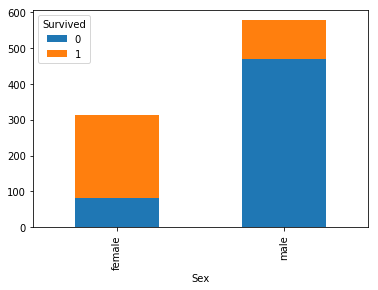

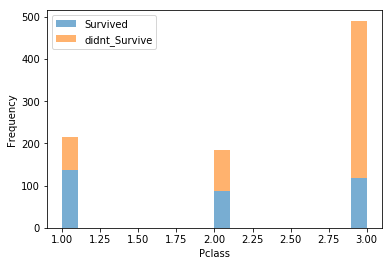

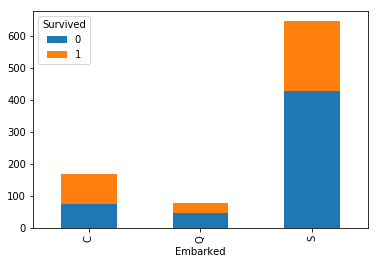

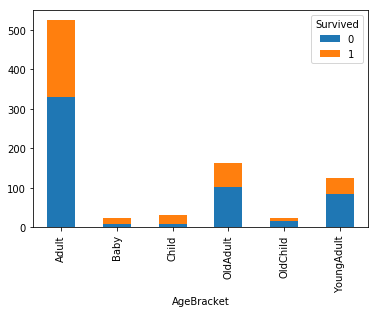

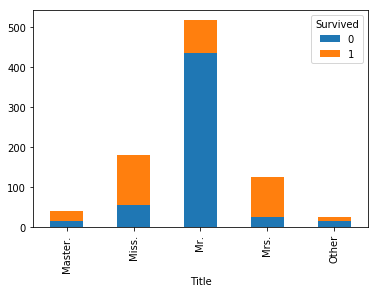

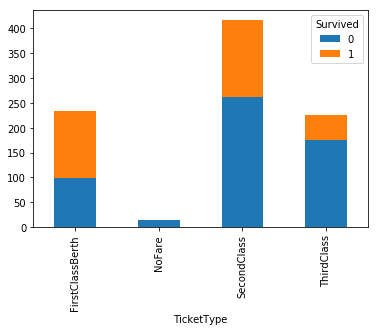

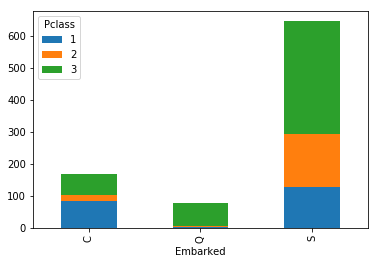

In [836]:
plot_survival_per_feature(titanic_training_LR, "Sex")
plot_survival_per_feature(titanic_training_LR, "Pclass")
plot_survival_per_feature(titanic_training_LR, "Embarked")
plot_survival_per_feature(titanic_training_LR, "AgeBracket")
plot_survival_per_feature(titanic_training_LR, "Title")
plot_survival_per_feature(titanic_training_LR, "TicketType")

plot_survival_per_feature_grouping(titanic_training_LR, "Embarked", "Pclass")

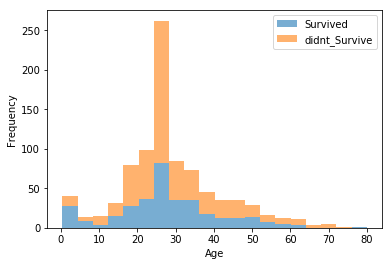

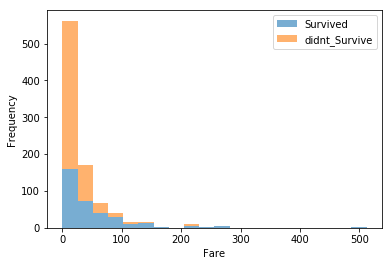

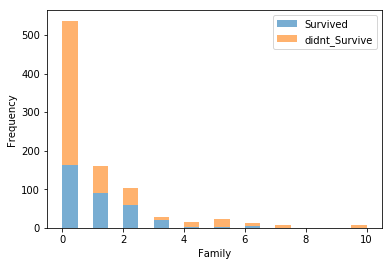

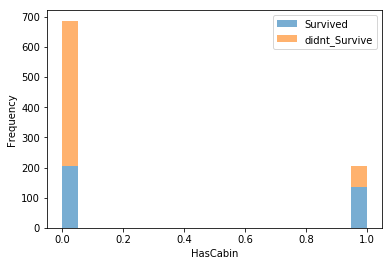

In [803]:
plot_survival_per_feature(titanic_training_LR, "Age")
plot_survival_per_feature(titanic_training_LR, "Fare")
plot_survival_per_feature(titanic_training_LR, "Family")
plot_survival_per_feature(titanic_training_LR, "HasCabin")

In [852]:
#Analysing the error rows
predictions = lr_clf_test.predict(titanic_training_LR_prepared)
pd.DataFrame({
        "PassengerId": titanic_training_LR["PassengerId"],
        "Survived": predictions
    }).to_csv('titanic_predictions_test.csv', index=False)